<a href="https://colab.research.google.com/github/PranjitGautam/Algorithm-Mini-Project/blob/master/object_removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code By Pranjit Gautam

In [5]:
!pip3 install opencv-contrib-python numpy
!wget https://drive.google.com/file/d/1WpZ5EI7kK33vXrwIb5JIACwCOBrkf8-V/view?usp=sharing
!wget https://drive.google.com/file/d/1P1Y-KyxrFTEWgvjTKjcpzGQ_NPtgM1K9/view?usp=sharing
!wget https://drive.google.com/file/d/1oNSOo_eQdrlcSHn563Db2mJPP_THwfsn/view?usp=sharing

--2021-04-26 08:29:39--  https://drive.google.com/file/d/1WpZ5EI7kK33vXrwIb5JIACwCOBrkf8-V/view?usp=sharing
Resolving drive.google.com (drive.google.com)... 64.233.187.101, 64.233.187.138, 64.233.187.139, ...
Connecting to drive.google.com (drive.google.com)|64.233.187.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘view?usp=sharing’

view?usp=sharing        [ <=>                ]  70.32K  --.-KB/s    in 0.1s    

2021-04-26 08:29:40 (552 KB/s) - ‘view?usp=sharing’ saved [72005]

--2021-04-26 08:29:40--  https://drive.google.com/file/d/1P1Y-KyxrFTEWgvjTKjcpzGQ_NPtgM1K9/view?usp=sharing
Resolving drive.google.com (drive.google.com)... 64.233.187.138, 64.233.187.139, 64.233.187.113, ...
Connecting to drive.google.com (drive.google.com)|64.233.187.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘view?usp=sharing.1’

view?usp=sharing.1      [ <=>               

In [2]:
import cv2 
import numpy as np
from google.colab.patches import cv2_imshow

In [3]:
# Crop to size of mask
# This is not a tight crop 
# Also ensures both sides are equal
def crop_image(image, mask):
    y_index, x_index = np.where(mask != 0)
    # Both arrays are sorted based on the contents of y_index
    # So x_index needs to be resorted based on its own contents
    x_index.sort()
    first_x = x_index[0]
    first_y = y_index[0]
    last_x = x_index[len(x_index)-1]
    last_y = y_index[len(y_index)-1]

    # find max width so crop will be square
    x_diff = last_x - first_x
    y_diff = last_y - first_y
    max_diff = x_diff if x_diff > y_diff else y_diff 

    # Increase size of cropped area
    min_y = int(first_y*.8)
    max_y = first_y + int(max_diff * 1.5)
    min_x = int(first_x*.8)
    max_x = first_x + int(max_diff * 1.5)
    return image[min_y:max_y, min_x:max_x], min_x, min_y


# Crop to area of white
# This is an optimization that means circle hough
# Doesn't have to run on the whole image 
def crop_to_ball(image):
    # Threshold for white
    mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask[mask < 220] = 0

    # Remove noise and convert to binary image
    kernel = np.ones((5,5),np.uint8)
    mask = cv2.erode(mask,kernel,iterations = 2)
    mask = cv2.bilateralFilter(mask,9,75,75)
    mask = cv2.dilate(mask,kernel,iterations = 5)
    mask = cv2.bilateralFilter(mask,9,75,75)
    mask[mask != 0] = 255

    return crop_image(image, mask)

# Use circle hough to check if a ball is present and return its dimensions
def check_for_ball(image):
    # Convert to grey and blur to prepare for CircleHough
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    gray = cv2.blur(gray,(5,5))
    height, _, _ = image.shape

    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1=130, param2=30, minRadius=int(height*.15), maxRadius=int(height*.38))
    if circles is not None:
        for x, y, r in circles[0]:
            return int(x), int(y), int(r), height
    return False

    

# Sample part of the image to be used to cover the removed object
def sample_image(image, x, y, r, height):
    # Take into consideration the width/height of the crop
    offset_multiplier = height * .60

    # Copy sample area of image to cover hole 
    sample = image[y-r-5:y+r+5, int(x-r-5-offset_multiplier):int(x+r+5-offset_multiplier)]
    image[y-r-5:y+r+5, x-r-5:x+r+5] = sample
    return image, sample

# Use inpainting to blend the sample with the original image
def inpaint_sample(image, x, y, r):
    # Copy image as cv2.line alters any image passed to it
    line = image.copy()
    line_size = 5

    # Create white lines to mask the top of the sample
    cv2.line(line, (x-r-line_size,y-r-line_size), (x+r+line_size, y-r-line_size), (255, 255, 255), line_size)
    cv2.line(line, (x-r-line_size,y-r-line_size), (x-r-line_size, y), (255, 255, 255), line_size)
    cv2.line(line, (x+r+line_size,y-r-line_size), (x+r+line_size, y), (255, 255, 255), line_size)
    
    # Convert image to grayscale then binary
    line = cv2.cvtColor(line,cv2.COLOR_BGR2GRAY)
    line[line != 255] = 0

    # Use mask to blend sample with the background
    sample = cv2.inpaint(image,line,5,cv2.INPAINT_NS)
    return sample

# If no samples are availible inpaint the whole hole
def radial_fill(image, x, y, r):
    # Copy image as cv2.circle alters any image passed to it
    original = image.copy()
    cv2.circle(image, (x, y+15), r+20, (255, 255, 255), -1)

    # Covert to gray and then binary
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image[image != 255] = 0

    radial = cv2.inpaint(original,image,3,cv2.INPAINT_NS)
    return radial


# This removes the ball from the scene and replaces 
# The hole it leaves with grass
def remove_ball(image):
    if(image is None):
        print("Image provided was empty")
        return False

    # Copy images to maintain original
    radial_src = image.copy()
    image_sample = image.copy()

    # Crop to white ball ROI
    cropped_image, min_x, min_y = crop_to_ball(image)

    # Check if a ball was detected
    try:
        x, y, r, width = check_for_ball(cropped_image)
    except TypeError:
        print("No balls were found")
        return False

    # Hough is calculated on cropped image
    # Cordinates need to be updated to match 
    # whole image
    x += min_x
    y += min_y

    sample_valid = True
    
    # Find out if a sample is availible
    try:
        # Get a sample from the image
        image_sample, sample = sample_image(image_sample, x, y, r, width)

        # Get a HSV copy to calculate Standard Deviation
        hsv = cv2.cvtColor(sample, cv2.COLOR_BGR2HSV)

        # Use standard deviation to determine 
        # if a sample area is good enough to be sampled
        _, std = cv2.meanStdDev(hsv)
        h_std, _,  _ =  std
        sample_valid = h_std < 5

    except ValueError:
        print("Sample out of bounds and invalid\nRadial inpaint will be used instead")
        sample_valid = False

    print("Ball has been replaced")

    if(sample_valid):
        return inpaint_sample(image_sample, x, y, r)
    else:
        return radial_fill(radial_src, x, y, r)

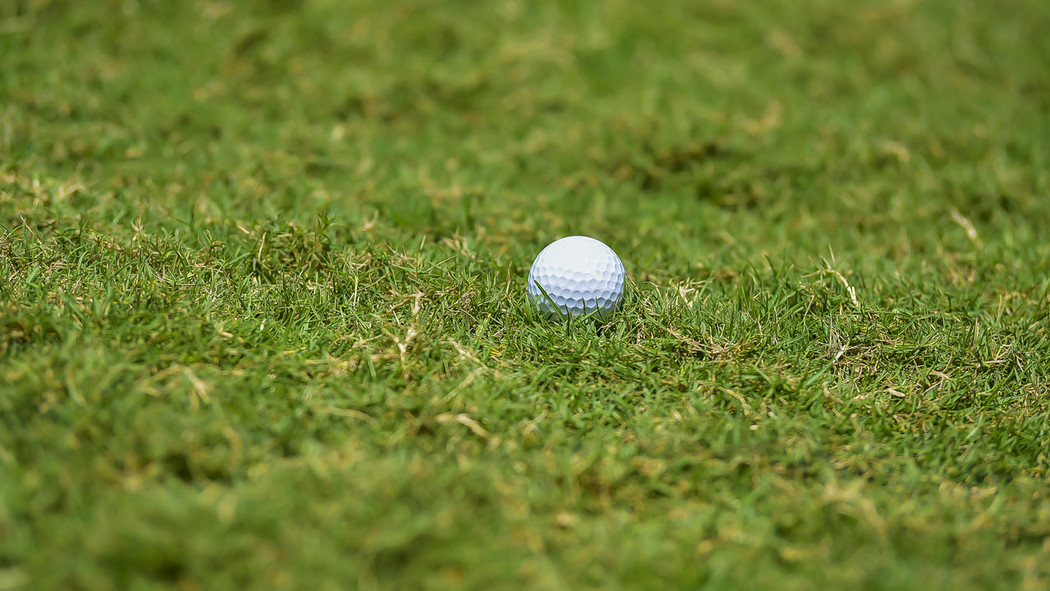

In [4]:
original_image = cv2.imread("./golf.jpg", 1)
cv2_imshow(original_image)

Ball has been replaced


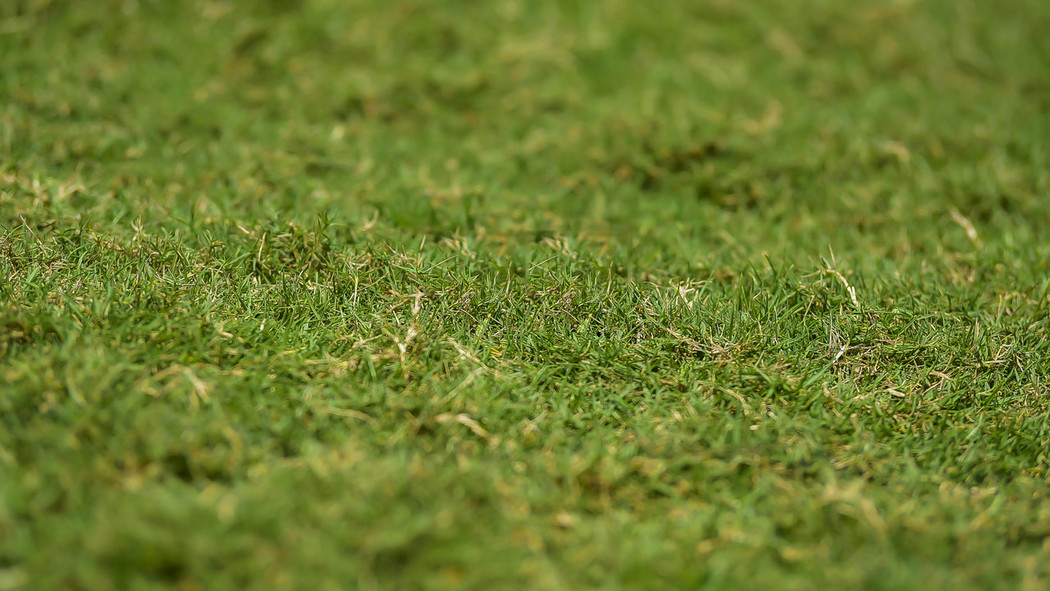

In [ ]:
cv2_imshow(remove_ball(original_image))

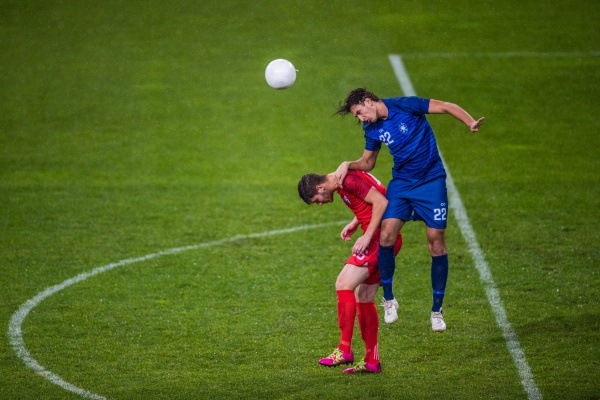

In [ ]:
original_image = cv2.imread("./spottheball.jpg", 1)
cv2_imshow(original_image)

Ball has been replaced


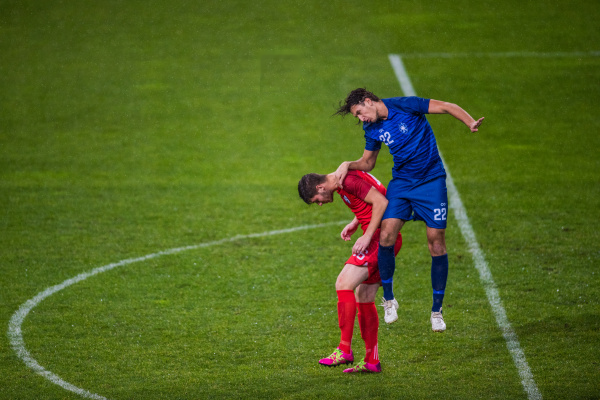

In [ ]:
cv2_imshow(remove_ball(original_image))

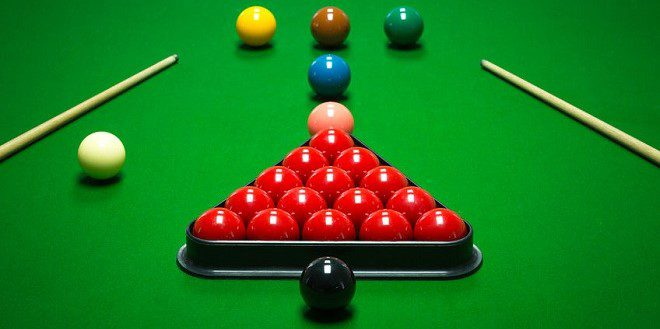

In [ ]:
original_image = cv2.imread("./snooker.jpg", 1)
cv2_imshow(original_image)

Ball has been replaced


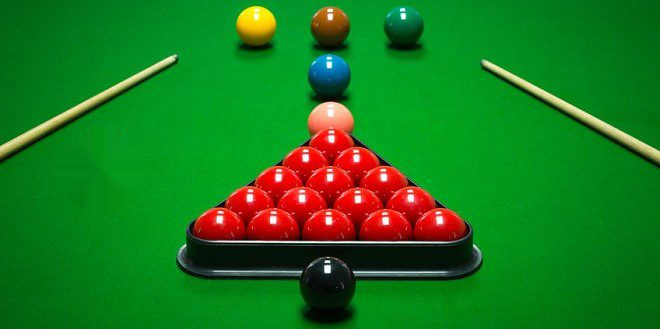

In [ ]:
cv2_imshow(remove_ball(original_image))